In [12]:
import pandas as pd
import numpy as np
from numpy import interp
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

#from scipy import stats 
#from scipy import signal
#import librosa
from librosa import core

#from itertools import chain
import sklearn
#from inspect import signature

import xgboost
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut, StratifiedKFold
#from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import make_pipeline
#import joblib
from sklearn.utils import shuffle
#from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, make_scorer, auc, balanced_accuracy_score

from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
import sys

from tqdm import tqdm
#from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

## Used E4_Event_only data data for the following codes

source: ttaichi_wear\Data\E4_Event_only\Sync_E4_401_1_S1_Event.csv

In [13]:
features_dataframe_normal = pd.read_csv(r'C:\Users\98768\Desktop\taichi\taichi_wear\features\taichi_adjusted\model_data\all\features_dataframe_normal.csv')
features_dataframe = pd.read_csv(r'C:\Users\98768\Desktop\taichi\taichi_wear\features\taichi_adjusted\model_data\all\features_dataframe.csv')

In [14]:
# Shuffling the data, and add in the truthlabels
features_dataframe_normal['Three-way Class'] = features_dataframe['Three-way Class']
features_dataframe_normal.reset_index(inplace=True)
features_dataframe_normal = shuffle(features_dataframe_normal, random_state = 0)

X_norm = features_dataframe_normal.drop(['Three-way Class', 'index', 'sum_first_15'], axis=1)
Y = features_dataframe_normal['Three-way Class']

In [15]:
Y.value_counts()

Three-way Class
0.0    2793
1.0    2404
2.0    1513
Name: count, dtype: int64

In [16]:
# oversampling function
def oversampling(X, Y):
    
    index = list(Y.value_counts().index)
    counts = list(Y.value_counts().values)

    index1 = index[0]
    index2 = index[1]

    counts1 = counts[0]
    counts2 = counts[1]

    if len(Y.value_counts()) == 2:
        max = np.max([counts1, counts2])
        oversample = RandomOverSampler(sampling_strategy={index1: max, index2: max})
    else:
        index3 = index[2]

        counts3 = counts[2]

        max = np.max([counts1, counts2, counts3])
        oversample = RandomOverSampler(sampling_strategy={index1: max, index2: max, index3: max})

    X_over, y_over = oversample.fit_resample(X, Y)

    return X_over, y_over

In [17]:
Y.value_counts()

Three-way Class
0.0    2793
1.0    2404
2.0    1513
Name: count, dtype: int64

In [18]:
X_over, y_over = oversampling(X_norm, Y)
y_over.value_counts()

Three-way Class
2.0    2793
1.0    2793
0.0    2793
Name: count, dtype: int64

In [19]:
def models(trainX, trainY1, model_name = 'random_forest'):

    '''
    training set: over_x, over_y
    model: model_name
    '''
    #loo = LeaveOneOut()
    loo = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    verbose_num = 3  # control how much progess info to display when fitting
    # tprs = []
    # mean_fpr = np.linspace(0, 1, 100)

    scores = {'accuracy' : make_scorer(balanced_accuracy_score), 
       #make_scorer(roc_auc_score, average = 'weighted', multi_class='ovr', , needs_proba=True),
       'precision' : make_scorer(precision_score, average = 'micro'),
       'recall' : make_scorer(recall_score, average = 'micro'), 
       'f1' : make_scorer(f1_score, average = 'micro')}
    
    # Random Forest
    if(model_name == 'random_forest'):
        rf_grid = RandomForestClassifier(random_state=0, class_weight='balanced')
        grid = {
            'n_estimators': [40,45,50],
            'max_depth' :   [15,20,25,None],
            #'class_weight': [None, 'balanced'],
            'max_features': ['auto','sqrt','log2', None, 5, 10, 15],
            'min_samples_leaf':[1,2,0.1,0.05]
        }
        grid_search = GridSearchCV(estimator=rf_grid, param_grid=grid, scoring=scores, n_jobs=1, cv=loo, \
                                   refit='accuracy', verbose=verbose_num, return_train_score=True)
    
    # Adaboost
    if(model_name == 'adaboost'):
        ada_grid = AdaBoostClassifier(random_state=0, algorithm='SAMME')
        grid = {
            'n_estimators': [50, 75, 100, 125, 150],
            'learning_rate':[0.01,.1, 1, 1.5, 2]
        }
        grid_search = GridSearchCV(ada_grid, param_grid=grid, scoring=scores, n_jobs=1, cv=loo, \
                                   refit='accuracy', verbose=verbose_num, return_train_score=True)
    
    # RBF SVM
    if(model_name == 'kernel_svm'):
        svc_grid = SVC(kernel = 'rbf', probability=True, random_state=0, class_weight='balanced')
        grid = {
            'gamma':[0.0001, 0.001, 0.1, 1, 10]
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring=scores, n_jobs=1, cv=loo, \
                                   refit='accuracy', verbose=verbose_num, return_train_score=True)

    # GBM
    if(model_name == 'gbm'):
        gbm_grid = GradientBoostingClassifier(random_state=0)
        grid = {
            'learning_rate':    [0.15,0.1,0.05],
            'n_estimators':     [50, 100, 150],
            'max_depth':        [2,4,7],
            'min_samples_split':[2,4],
            'min_samples_leaf': [1,3],
            'max_features':     [4, 5, 6, None, 'auto','sqrt','log2']
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring=scores, n_jobs=1, cv=loo, \
                                   refit='accuracy', verbose=verbose_num, return_train_score=True)
    
    # Xgboost
    if(model_name=='xgboost'):
        xgb_grid = xgboost.XGBClassifier(random_state=0, objective='multi:softprob')
        grid = {
            'min_child_weight': [1, 5],
            'gamma':            [0.1, 0.5, 1, 1.5, 2],
            'subsample':        [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth':        [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring=scores, n_jobs=1, cv=loo, \
                                   refit= 'accuracy', verbose=verbose_num, return_train_score=True)
    
    # KNN `
    if(model_name == 'knn'):
        knn_grid = KNeighborsClassifier()
        grid = {
            'n_neighbors': [1, 3, 4, 5, 10],
            'p':           [1, 2, 3, 4, 5]
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring=scores, n_jobs=1, cv=loo, \
                                   refit='accuracy', verbose=verbose_num, return_train_score=True)
        
    # Decision Tree 
    if(model_name == 'decision_tree'):
        dec_grid = DecisionTreeClassifier(random_state=0, class_weight='balanced')
        grid = {
            'min_samples_split': range(2, 50)
        }
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring=scores, n_jobs=1, cv=loo, \
                                   refit='accuracy', verbose=verbose_num, return_train_score=True)
    
    # Linear SVM 
    if(model_name == 'linear_svm'):
        lsvm_grid = LinearSVC(random_state=0, class_weight='balanced')
        grid = {
            'loss': ['hinge','squared_hinge']
        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring=scores, n_jobs=1, cv=loo, \
                                   refit='accuracy', verbose=verbose_num, return_train_score=True)
    
    #  Logistic regression ``
    if(model_name == 'logistic_regression'):
        grid_search = LogisticRegression(random_state=0, multi_class='multinomial', class_weight='balanced')
        
    # Fitting on the training set to find the optimal hyperparameters
    grid_search.fit(trainX, trainY1)

    try:
        best_index = grid_search.cv_results_['mean_test_accuracy'].argmax()
        params = grid_search.cv_results_['params'][best_index]
        print('best_params: ', params)

    except:
        pass
    print('test set accuracy')
    print('Mean cv accuracy:', grid_search.cv_results_['mean_test_accuracy'][best_index])
    print('Standard deviation accuracy:' , grid_search.cv_results_['std_test_accuracy'][best_index])

    #print('test set AUC')
    #print('Mean cv AUC:', grid_search.cv_results_['mean_test_auc'][best_index])
    #print('Standard deviation AUC:' , grid_search.cv_results_['std_test_auc'][best_index])

    print('test set precision')
    print('Mean cv precision:', grid_search.cv_results_['mean_test_precision'][best_index])
    print('Standard deviation precision:' , grid_search.cv_results_['std_test_precision'][best_index])

    print('test set recall')
    print('Mean cv recall:', grid_search.cv_results_['mean_test_recall'][best_index])
    print('Standard deviation recall:' , grid_search.cv_results_['std_test_recall'][best_index])

    print('test set F1')
    print('Mean cv F1:', grid_search.cv_results_['mean_test_f1'][best_index])
    print('Standard deviation F1:' , grid_search.cv_results_['std_test_f1'][best_index])

    #print('Mean cv accuracy on train set:', grid_search.cv_results_['mean_train_accuracy'][grid_search.best_index_])
    #print('Standard deviation on train set:', grid_search.cv_results_['std_train_accuracy'][grid_search.best_index_])
    

    # Best model from grid search 
    classifier = grid_search.best_estimator_ 
    print ('Best estimator = ', classifier)
    for i, (train, test) in tqdm(enumerate(loo.split(trainX, trainY1)), desc='Predicting w/ current', total=len(trainX)):
        classifier.fit(trainX.loc[train], trainY1.loc[train])
        try:
            y_pred_proba = np.ravel(classifier.predict_proba(trainX.loc[test]), order='F')
        except:
            y_pred_proba = np.ravel(classifier._predict_proba_lr(trainX.loc[test]), order='F')

        #fpr, tpr, _ = roc_curve(trainY1.loc[test], y_pred_proba)
        #interp_tpr = interp(mean_fpr, fpr, tpr)
        #interp_tpr[0] = 0.0
        #tprs.append(interp_tpr)
    #mean_tpr = np.mean(tprs, axis=0)
    #mean_tpr[-1] = 1.0
    #return mean_tpr

    # return the prob for each label
    return y_pred_proba

In [22]:
ml_models = ['adaboost', 'xgboost', 'gbm', 'random_forest','knn', 'linear_svm', 'decision_tree', 'kernel_svm']
#ml_models = ['linear_svm', 'adaboost']
predicted_probs_df = pd.DataFrame(columns=ml_models) 

pbar = tqdm(total=len(ml_models), desc='Training models')

# Specify the directory where you want to store the output files
output_directory = 'output'

# Create the directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for ml_model in ml_models:
    print(ml_model)
    
    # Construct the full path for the output file
    output_file = os.path.join(output_directory, f'{ml_model}_output.txt')
    
    # Redirect stdout to the file
    with open(output_file, 'w') as f:
        sys.stdout = f  # Redirect stdout to the file
        predict_probs = models(X_norm, Y, ml_model)
        sys.stdout = sys.__stdout__  # Restore stdout to its original state
    
    predicted_probs_df[ml_model] = predict_probs
    print('-----------------------------------')
    
    # update the progress bar
    pbar.update(1)

# close the progress bar
pbar.close()

predicted_probs_df

Training models:  12%|█▎        | 1/8 [03:19<23:18, 199.81s/it]

In [21]:
stopper

NameError: name 'stopper' is not defined

### Overfitting? - Feature Selection

 metric does not change almost, too easy of a task?

 test metrix either 0 or 1

 normalizing using calculatoin or StandardScaler

In [ ]:
X_over.corr()

,mean,sd,cv,rms,autocorr_lag0,corr_xy,corr_xz,corr_yz,mad,mcr_xyz,sma_xyz,se,p2p_xyz_mean,p2p_xyz_std,p2p_xyz_max
mean,1.000000,0.818966,0.793094,0.983415,0.983244,0.004187,0.049491,-0.021656,0.831770,-0.471994,0.008672,0.981999,0.823057,0.781374,0.743022
sd,0.818966,1.000000,0.998528,0.893311,0.881086,-0.066178,-0.003745,-0.190464,0.993742,-0.581417,-0.057322,0.885800,0.954724,0.939118,0.922609
cv,0.793094,0.998528,1.000000,0.870533,0.856485,-0.068633,-0.005913,-0.195671,0.990294,-0.587440,-0.060395,0.861502,0.948780,0.935589,0.922404
rms,0.983415,0.893311,0.870533,1.000000,0.998913,-0.016739,0.029551,-0.069222,0.903076,-0.499698,-0.012107,0.999189,0.888973,0.855785,0.818090
autocorr_lag0,0.983244,0.881086,0.856485,0.998913,1.000000,-0.014977,0.027672,-0.068005,0.892397,-0.488900,-0.011093,0.999676,0.879959,0.846017,0.806783
corr_xy,0.004187,-0.066178,-0.068633,-0.016739,-0.014977,1.000000,0.042660,-0.101884,-0.077781,0.011877,0.385350,-0.016358,-0.053875,-0.030876,-0.035147
corr_xz,0.049491,-0.003745,-0.005913,0.029551,0.027672,0.042660,1.000000,0.191837,-0.020377,0.065106,0.197626,0.030523,-0.019145,-0.006341,-0.015033
corr_yz,-0.021656,-0.190464,-0.195671,-0.069222,-0.068005,-0.101884,0.191837,1.000000,-0.186483,0.059967,-0.225739,-0.070733,-0.162628,-0.163669,-0.167596
mad,0.831770,0.993742,0.990294,0.903076,0.892397,-0.077781,-0.020377,-0.186483,1.000000,-0.587209,-0.065842,0.896430,0.955342,0.919265,0.898268
mcr_xyz,-0.471994,-0.581417,-0.587440,-0.499698,-0.488900,0.011877,0.065106,0.059967,-0.587209,1.000000,0.279139,-0.488941,-0.556601,-0.544574,-0.540003


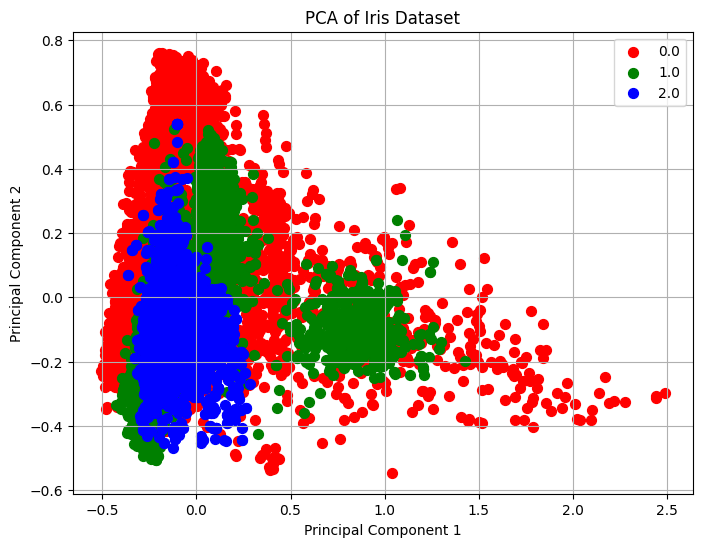

In [ ]:
n_components=15  # how many to keep

pca = PCA(n_components)
X_pca = pca.fit_transform(X_over)

pc_columns = [f'PC{i}' for i in range(1, n_components + 1)]
df_pca = pd.DataFrame(data=X_pca, columns=pc_columns)
df_pca['Target'] = y_over

# plot it
plt.figure(figsize=(8, 6))
targets = np.unique(y_over)
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indices_to_keep = df_pca['Target'] == target
    plt.scatter(df_pca.loc[indices_to_keep, 'PC1'], df_pca.loc[indices_to_keep, 'PC2'], c=color, s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Iris Dataset')
plt.legend(targets, loc='best')
plt.grid()
plt.show()

In [ ]:
n_components = 2  # to keep
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_over)

# contribution
pc_columns = [f'PC{i}' for i in range(1, n_components + 1)]
components_df = pd.DataFrame(data=X_pca, columns=pc_columns)
print("Principal Components:")
print(components_df)

Principal Components:
           PC1       PC2
0    -0.010386 -0.085431
1     0.299052  0.240471
2    -0.080151 -0.255845
3     0.125954  0.269672
4     0.103703 -0.260789
...        ...       ...
8374  0.008209 -0.309816
8375 -0.157385 -0.143252
8376 -0.237296 -0.030213
8377 -0.274873 -0.286207
8378 -0.123987  0.156259

[8379 rows x 2 columns]
